# Problem Definition
Using limit order book and executed trades data from the previous *WINDOW_LENGTH* seconds, identify whether a trade (long or short) placed now will return 25 basis points or more (before fees) in the next *HORIZON* seconds.

Deadline: April 31st, 23:59

---
In this notebook, we implement the architecture described in the [DeepLOB paper](https://arxiv.org/abs/1808.03668) and demonstrated in [this](https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books) repo. Full training is probably best done on Google Colab, since it allows access to a GPU.

In [1]:
# limit gpu memory

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

In [2]:
# load packages
import pandas as pd
import pickle
import numpy as np
import keras
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU

from keras.utils import np_utils
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
import tensorflow_addons as tfa

# set random seeds
np.random.seed(1)
tf.random.set_seed(2)

# Data preparation
"
We used no auction dataset that is normalised by decimal precision approach in their work. For illustration purpose, we don't have validation dataset here but you should include it in your work. The first seven days are training data and the last three days are testing data.

The first 40 columns of the FI-2010 dataset are 10 levels ask and bid information for a limit order book and we only use these 40 features in our network. The last 5 columns of the FI-2010 dataset are the labels with different prediction horizons.
"

In [3]:
train_lob = pd.read_csv('/Users/Sanjit/Repos/Predictive Analytics/train_orderbook.csv') #train orderbook
test_lob = pd.read_csv('/Users/Sanjit/Repos/Predictive Analytics/test_orderbook.csv') #test orderbook 

#split training set into train and validation
train_lob, val_lob = train_test_split(train_lob, test_size=0.2, shuffle=False)

In [4]:
#If we label before scaling, we know exactly what they mean. 
#Label 1 means an increase of 25 basis points of the midprice in the next k seconds.
#Label -1 means a decrease, and 0 means neither of those two.
#Note: this code isn't the most efficient

def label_before_scale(df):
    THRESHOLD = 0.0025
    mid_price = ((df['ask1'] + df['bid1']) / 2).to_numpy()
    all_labels = np.array([0]*len(mid_price)).reshape(-1, 1)
    horizons = [1, 2, 3, 5, 10, 15, 30]

    for k in horizons:
        labels = []
        for i in range(len(mid_price)-k):
            pct_change = (mid_price[i+k] - mid_price[i]) / mid_price[i]
            if pct_change >= THRESHOLD:
                labels = np.append(labels,  1)
            elif pct_change <= -THRESHOLD:
                labels = np.append(labels,  -1)
            else:
                labels = np.append(labels, 0)
        if len(labels) < len(mid_price):
            labels = np.append(labels, [np.nan]*(len(mid_price) - len(labels)))
        all_labels = np.hstack((all_labels, np.array(labels).reshape(-1,1)))
    return all_labels[:len(mid_price)-max(horizons),1:]

train_label = label_before_scale(train_lob)
val_label = label_before_scale(val_lob)
test_label = label_before_scale(test_lob)

## Data normalisation
They normalise before calculating labels. In v2.ipynb, I found that this doesn't work well for our application, since the labels lose meaning. So I'm normalising after calculating labels.

In [5]:
#Need to normalise new data in the same way as old data, so use the scaler fit on the training set to scale validation and test sets.
#In the paper it seems that they scale the entire orderbook using a single scaler

def fit_and_scale(df):
    df = df.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1']).to_numpy()
    scaler = StandardScaler()
    scaler.fit(df)
    df = scaler.transform(df)
    return df, scaler

def scale_new(df, scaler):
    df = df.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1']).to_numpy()
    df = scaler.transform(df)
    return df

train_lob, scaler = fit_and_scale(train_lob)
val_lob = scale_new(val_lob, scaler)
test_lob = scale_new(test_lob, scaler)

## Data labelling (Ignore)

In [85]:
'''
#See the bottom of Page 13 in https://arxiv.org/pdf/1705.03233.pdf for a description of the labels.
def label(df):
    mid_price = ((df['ask1'] + df['bid1']) / 2).to_numpy()
    all_labels = np.array([0]*len(mid_price)).reshape(-1, 1)

    for k in [1, 2, 3, 5, 10]:
        labels = []
        for i in range(len(mid_price) - k):
            summation = 0
            for j in range(i+1, i+k+1):
                summation += mid_price[j] - mid_price[i]
            numerator = summation / k
            labels.append(numerator / mid_price[i])

        labels.extend([0]*k) #pad with zeroes to allow stacking into single np.array
        labels = np.array(labels).reshape(-1, 1)
        all_labels = np.hstack((all_labels, labels))

    return all_labels[:(len(all_labels)-10),1:]
'''
'''
def label_after_scale(df, threshold):
    #mid_price = ((df['ask1'] + df['bid1']) / 2).to_numpy()
    mid_price = ((df[:,0] + df[:,2]) / 2)
    all_labels = np.array([0]*len(mid_price)).reshape(-1, 1)

    for k in [1, 2, 3, 5, 10, 15, 30]:
        labels = []
        for i in range(len(mid_price)):
            m_minus = np.mean(mid_price[i-k:i])
            m_plus = np.mean(mid_price[i+1:i+k+1])
            label_4 = (m_plus - m_minus) / m_minus
            if label_4 > threshold:
                labels = np.append(labels,  1)
            elif label_4 < -threshold:
                labels = np.append(labels,  -1)
            else:
                labels = np.append(labels, 0) #currently, nans are mapped to 0
        all_labels = np.hstack((all_labels, np.array(labels).reshape(-1,1)))
    return all_labels[:,1:]
'''

"\ndef label_after_scale(df, threshold):\n    #mid_price = ((df['ask1'] + df['bid1']) / 2).to_numpy()\n    mid_price = ((df[:,0] + df[:,2]) / 2)\n    all_labels = np.array([0]*len(mid_price)).reshape(-1, 1)\n\n    for k in [1, 2, 3, 5, 10, 15, 30]:\n        labels = []\n        for i in range(len(mid_price)):\n            m_minus = np.mean(mid_price[i-k:i])\n            m_plus = np.mean(mid_price[i+1:i+k+1])\n            label_4 = (m_plus - m_minus) / m_minus\n            if label_4 > threshold:\n                labels = np.append(labels,  1)\n            elif label_4 < -threshold:\n                labels = np.append(labels,  -1)\n            else:\n                labels = np.append(labels, 0) #currently, nans are mapped to 0\n        all_labels = np.hstack((all_labels, np.array(labels).reshape(-1,1)))\n    return all_labels[:,1:]\n"

In [6]:
MAX_HORIZON = 30

'''
#It's not clear what this threshold means, since this is a threshold for scaled data
THRESHOLD = 0.001 

train_label = label_after_scale(train_lob, THRESHOLD)
val_label = label_after_scale(val_lob, THRESHOLD)
test_label = label_after_scale(test_lob, THRESHOLD)
'''

train_lob = train_lob[:len(train_lob)-MAX_HORIZON]
val_lob = val_lob[:len(val_lob)-MAX_HORIZON]
test_lob = test_lob[:len(test_lob)-MAX_HORIZON]

print("Train shapes: ", train_lob.shape, train_label.shape)
print("Validation shapes: ", val_lob.shape, val_label.shape)
print("Test shapes: ", test_lob.shape, test_label.shape)

Train shapes:  (68266, 40) (68266, 7)
Validation shapes:  (17044, 40) (17044, 7)
Test shapes:  (84283, 40) (84283, 7)


## Building dataset

In [7]:
#From the notebook provided by authors of the paper. I don't understand this in detail. 
def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX.reshape(dataX.shape + (1,)), dataY

In [8]:
# prepare training data. We feed past 100 observations into our algorithms and choose the prediction horizon. 
LOOKBACK = 100
#In the label functions, horizons = [1, 2, 3, 5, 10, 15, 30]. So HORIZON = 6 corresponds to a 30 second horizon
HORIZON = 6

trainX_CNN, trainY_CNN = data_classification(train_lob, train_label, T=LOOKBACK)
trainY_CNN = trainY_CNN[:,HORIZON] - 1
trainY_CNN = np_utils.to_categorical(trainY_CNN, 3)

# prepare val data.
valX_CNN, valY_CNN = data_classification(val_lob, val_label, T=LOOKBACK)
valY_CNN = valY_CNN[:,HORIZON] - 1
valY_CNN = np_utils.to_categorical(valY_CNN, 3)

# prepare test data.
testX_CNN, testY_CNN = data_classification(test_lob, test_label, T=LOOKBACK)
testY_CNN = testY_CNN[:,HORIZON] - 1
testY_CNN = np_utils.to_categorical(testY_CNN, 3)

# Model
Implement the DeepLOB model as described in the author's example notebook.

## Class weights

In [10]:
class_counts = trainY_CNN.sum(axis=0)
class_frequencies = class_counts / trainY_CNN.shape[0]
print("Class counts in train: ", trainY_CNN.sum(axis=0)) 
print("Class frequencies in train: ", class_frequencies)
print("Index 0 corresponds to BUY, index 1 corresponds to SELL", "\n")

# See https://stackoverflow.com/questions/60307239/setting-bias-for-multiclass-classification-python-tensorflow-keras
#0 means buy, 1 means sell, 2 means hold
weight_for_0 = (1 / class_counts[0])*(class_counts.sum())/3.0 
weight_for_1 = (1 / class_counts[1])*(class_counts.sum())/3.0
weight_for_2 = (1 / class_counts[2])*(class_counts.sum())/3.0

#For the class_weight argument in tf.keras.model.fit()
#See https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights for the bivariate case
#See https://stackoverflow.com/questions/60307239/setting-bias-for-multiclass-classification-python-tensorflow-keras for the trivariate case
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Class counts in train:  [  238.   105. 67824.]
Class frequencies in train:  [0.00349143 0.00154033 0.99496824]
Index 0 corresponds to BUY, index 1 corresponds to SELL 

Weight for class 0: 95.47
Weight for class 1: 216.40
Weight for class 2: 0.34


In [13]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      tfa.metrics.F1Score(3, name='F1')
]

def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
    
    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    ###### Set the correct initial bias ######
    '''
    See https://stackoverflow.com/questions/60307239/setting-bias-for-multiclass-classification-python-tensorflow-keras
    
    Solve simulaneously (f is frequency, b is bias):
    f1 = e^b1 / (e^b1 + e^b2 + e^b3) = 0.00349143
    f2 = e^b2 / (e^b1 + e^b2 + e^b3) = 0.00154033
    f3 = e^b3 / (e^b1 + e^b2 + e^b3) = 0.99496824
    Then output bias = [b1, b2, b3]

    One solution is bi = ln(fi), since f1 + f2 + f3 = 1
    There seems to be other solutions https://tinyurl.com/ywu4prkt (WolframAlpha systems of equations calculator)
    '''
    output_bias = [np.log(class_frequencies[0]), np.log(class_frequencies[1]), np.log(class_frequencies[2])]
    output_bias = tf.keras.initializers.Constant(output_bias)    
    ##########################################

    # build the output layer
    out = Dense(3, activation='softmax', bias_initializer=output_bias)(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=METRICS)

    return model

deeplob = create_deeplob(100, 40, 64)

## Callbacks

In [14]:
#~9 minutes for 1 epoch on my laptop!
EPOCHS = 1
#In the paper they used a small batchsize, whereas in the tf guide, they used a large one. Experiment with both. 
BATCH_SIZE = 32

# Create a callback that saves the model's weights
#checkpoint_path = "/Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/DeepLOB_withBiasAndWeights.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,  
    save_weights_only=True
    verbose=1)

#Stops training early if val_prc fails to increase for 10 epochs in a row 
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='auto',
    restore_best_weights=True)

"\nearly_stopping = tf.keras.callbacks.EarlyStopping(\n    monitor='val_F1', \n    verbose=1,\n    patience=10,\n    mode='max',\n    restore_best_weights=True)\n"

## Training

In [15]:
history = deeplob.fit(
    trainX_CNN,
    trainY_CNN, 
    epochs = EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(valX_CNN, valY_CNN), 
    callbacks=[cp_callback, early_stopping], 
    class_weight=class_weight,
    verbose=1)

1066/1066 [==============================] - ETA: 0s - loss: 3.2703 - tp: 67824.0000 - fp: 343.0000 - tn: 135991.0000 - fn: 343.0000 - accuracy: 0.9966 - precision: 0.9950 - recall: 0.9950 - auc: 0.9964 - prc: 0.9927 - F1: 0.3325
Epoch 00001: saving model to /Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/DeepLOB_withBiasAndWeights.ckpt
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/DeepLOB_withBiasAndWeights.ckpt/assets
1066/1066 [==============================] - 883s 828ms/step - loss: 3.2703 - tp: 67824.0000 - fp: 343.0000 - tn: 135991.0000 - fn: 343.0000 - accuracy: 0.9966 - precision: 0.9950 - recall: 0.9950 - auc: 0.9964 - prc: 0.9927 - F1: 0.3325 - val_loss: 0.3535 - val_tp: 16890.0000 - val_fp: 55.0000 - val_tn: 33835.0000 - val_fn: 55.0000 - val_accuracy: 0.9978 - val_precision: 0.9968 - val_recall: 0.9968 - val_auc: 0.9960 - val_prc: 0.99

# Evaluation

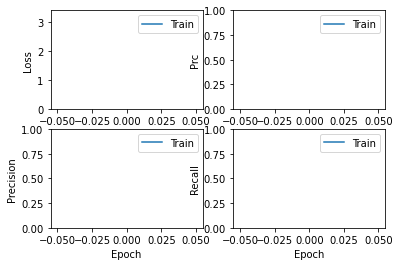

In [17]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric])
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

In [21]:
checkpoint_path = "/Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/DeepLOB_withBiasAndWeights.ckpt"
deeplob.load_weights(checkpoint_path) #All we have to do before this line is to define and compile the model

ValueError: Unable to restore custom object of type _tf_keras_metric currently. Please make sure that the layer implements `get_config`and `from_config` when saving. In addition, please use the `custom_objects` arg when calling `load_model()`.

In [18]:
preds = deeplob.predict(testX_CNN)

ipykernel_launcher:20: RuntimeWarning: invalid value encountered in long_scalars
Precision:  nan
Precision:  nan
Precision:  0.991696759479236


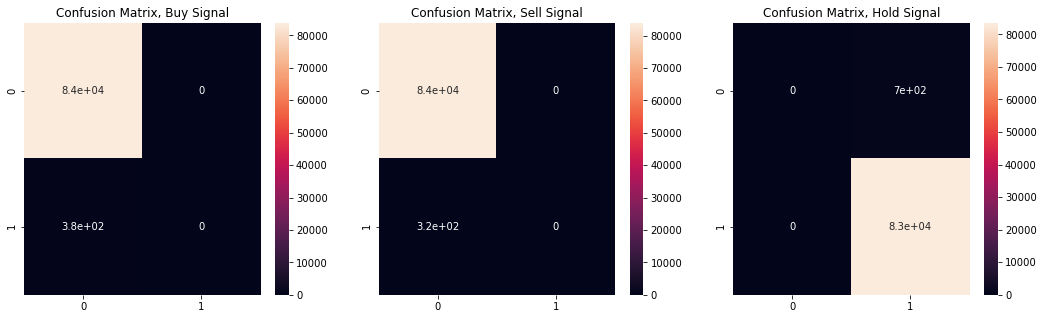

In [19]:
def evaluate_classification_model(predictions):
    y_pred = np.argmax(predictions, axis=1) #0 means buy, 1 means sell, 2 means hold
    y_true = np.argmax(testY_CNN, axis=1) #0 means buy, 1 means sell, 2 means hold

    #Prints a confusion matrix for each label:
    # TN FP
    # FN TP
    #FN = missed opportunities to trade, FP = trades which shouldn't have been placed
    #Accuracy = TP + TN / TP + TN + FP + FN
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    
    fig, ax = plt.subplots(ncols = 3, figsize=(18, 5), nrows = 1)
    names = ['Buy', 'Sell', 'Hold']
    for i in range(len(confusion_matrices)):
        sns.heatmap(confusion_matrices[i], ax=ax[i], annot=True)
        ax[i].set_title(f"Confusion Matrix, {names[i]} Signal")
    
    #We only care about the ratio TP / (TP + FP), i.e. we care about Precision
    for m in confusion_matrices:
        print("Precision: ", m[1, 1]/(m[1, 1] + m[0, 1]))

evaluate_classification_model(preds)

We still have the probem of incredibly imbalanced classes. Fixing this is the next order of business.
* https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
* https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

---

Update:

No evidence that it's helped yet, although I'm comparing two trainings on just one epoch. So the next steps are:
* train on a subset for multiple epochs. E.g. let train be first 5000 rows of train orderbook, let test be next 5000 rows of train orderbook, the split train into train and val. 
* train on the full dataset for multiple epochs. 
* See if it's quicker to train on Google Colab.

The aim right now is to just get some Buy and Sell predictions coming through, rather than the model predicting Hold all the time.

---
